In [11]:
import pandas as pd

df = pd.read_csv('./fredupdated.csv', parse_dates=['observation_date'])


df.set_index('observation_date', inplace=True)

df.head(5)

start_date = '1959-01-01'

df = df.loc[start_date:]

df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100


df.drop(columns=['CPIAUCSL'], inplace=True)


df.head(5)



,UNRATE,GDP,PCE,FEDFUNDS,GS10,M2SL,GDPC1,CIVPART,PPIACO,CES0500000003,Inflation_Rate
observation_date,,,,,,,,,,,
1959-01-01,5.8,510.330,309.5,2.57,3.99,287.8,3352.129,59.2,31.700,NaN,NaN
1959-04-01,5.1,522.653,315.5,3.08,4.26,292.1,3427.667,59.3,31.767,NaN,NaN
1959-07-01,5.3,525.034,320.7,3.58,4.50,296.1,3430.057,59.3,31.667,NaN,NaN
1959-10-01,5.6,528.600,322.9,3.99,4.58,297.1,3439.832,59.3,31.533,NaN,NaN
1960-01-01,5.1,542.648,326.4,3.93,4.49,298.6,3517.181,58.9,31.667,NaN,NaN


In [12]:
df.info()
df.drop(columns=['CES0500000003'], inplace=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1959-01-01 to 2025-01-01
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UNRATE          264 non-null    float64
 1   GDP             264 non-null    float64
 2   PCE             264 non-null    float64
 3   FEDFUNDS        264 non-null    float64
 4   GS10            264 non-null    float64
 5   M2SL            264 non-null    float64
 6   GDPC1           264 non-null    float64
 7   CIVPART         264 non-null    float64
 8   PPIACO          264 non-null    float64
 9   CES0500000003   75 non-null     float64
 10  Inflation_Rate  253 non-null    float64
dtypes: float64(11)
memory usage: 24.8 KB


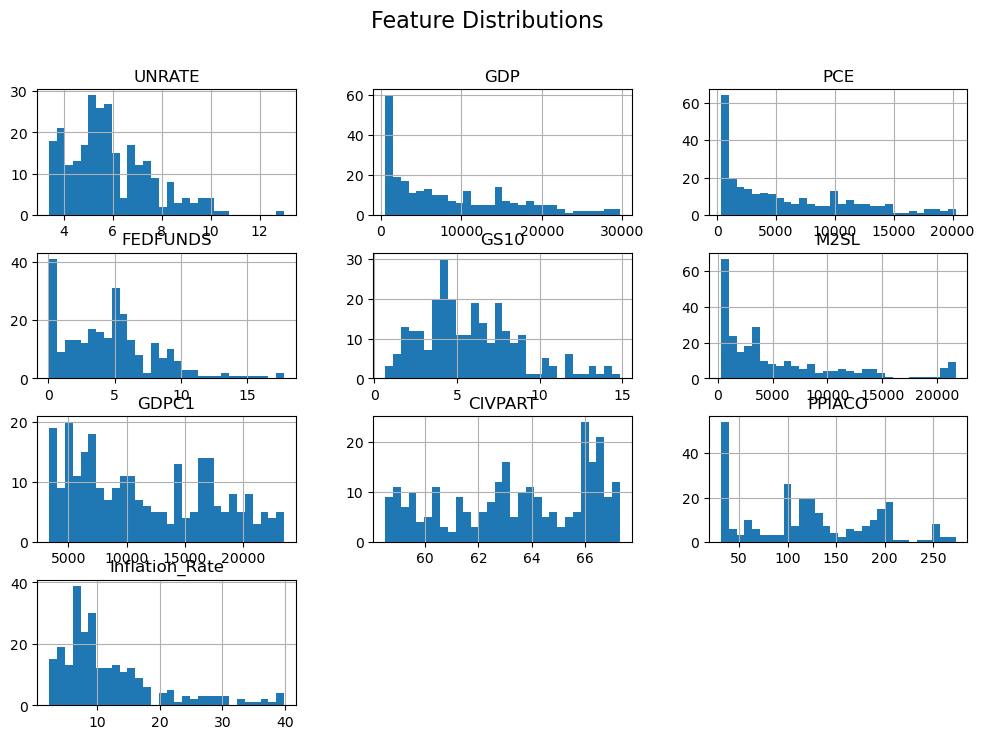

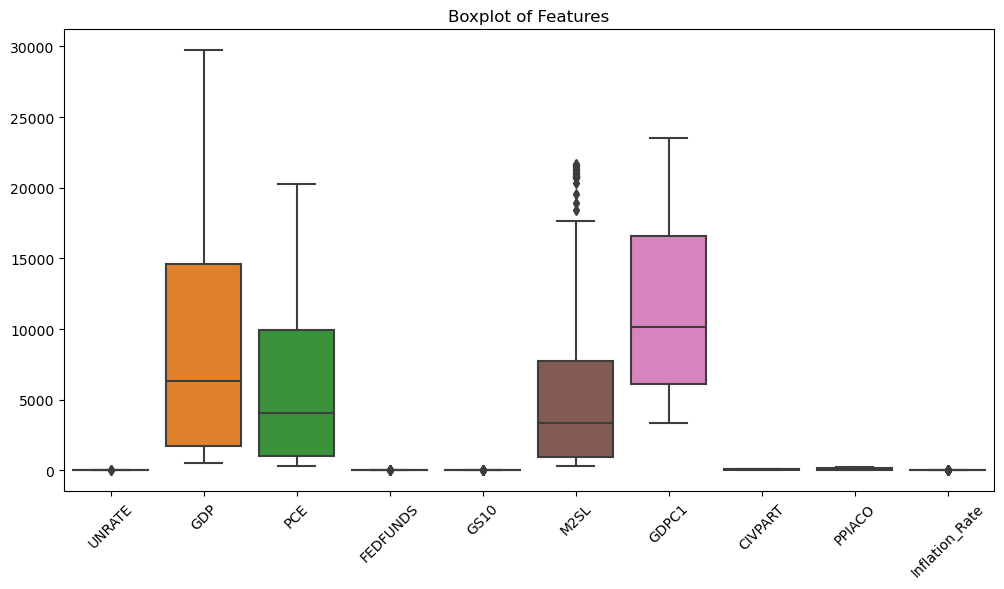

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # Histograms
df.hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of Features")
plt.show()


This version of the annual inflation rate is calculated by downloading the yearly CPI (vs. monthly as before) and again using the same formula to calculate yearly inflation rate. We note significant differences in calculated vs. actual inflation rates versus the other example.

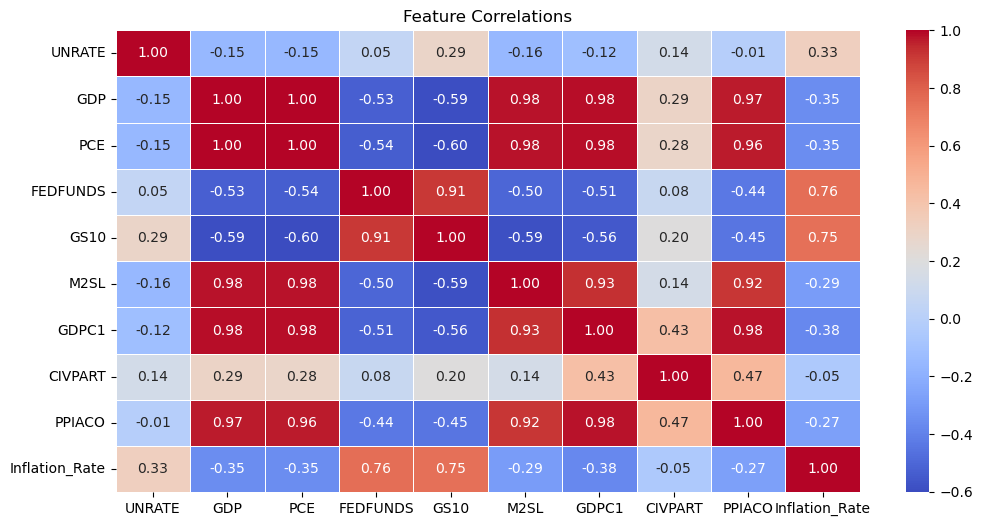

/Users/rayva/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


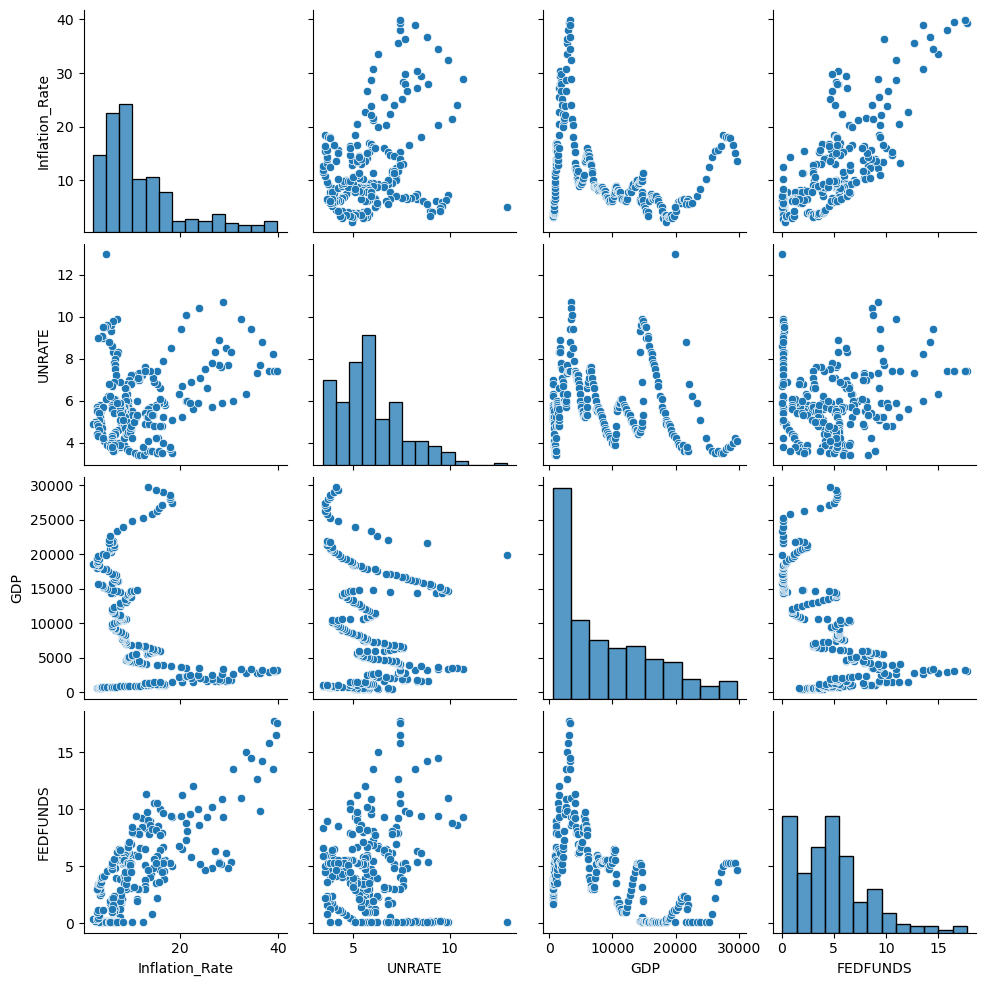

In [15]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlations")
plt.show()

# Plotting only a few right now

sns.pairplot(df[['Inflation_Rate', 'UNRATE', 'GDP', 'FEDFUNDS']])
plt.show()
